In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pyemma
from pyemma.util.contexts import settings
import pandas as pd
import mdtraj as md

from molpx.generate import projection_paths

In [2]:
files = ['data/pentapeptide-{:02d}-500ns-impl-solv.xtc'.format(i) for i in range(25)]
pdb = 'data/pentapeptide-impl-solv.pdb'

In [3]:
k_a = 100
k_b = 10
k_c = 105


torsions_feat = pyemma.coordinates.featurizer(pdb)
torsions_feat.add_backbone_torsions(cossin=True, periodic=False)
data_a = pyemma.coordinates.load(files, features=torsions_feat)


distances_feat = pyemma.coordinates.featurizer(pdb)
distances_feat.add_distances(
    distances_feat.pairs(distances_feat.select_Backbone(), excluded_neighbors=2), periodic=False)
data_b = pyemma.coordinates.load(files, features=distances_feat)

Obtaining file info:   0%|                                                                                    …

getting output of FeatureReader:   0%|                                                                        …

Obtaining file info:   0%|                                                                                    …

getting output of FeatureReader:   0%|                                                                        …

In [4]:
# see http://www.emma-project.org/latest/tutorials/notebooks/00-pentapeptide-showcase.html
tau = 5
tica_lag = 5
dim = 5


# Model 1 - data_a + k_a
tica_1 = pyemma.coordinates.tica(data_a, lag=tica_lag, dim=dim)
ttrajs_1 = tica_1.get_output()
kmeans_1 = pyemma.coordinates.cluster_kmeans(ttrajs_1, k=k_a, max_iter=1000)
dtrajs_1 = kmeans_1.dtrajs
msm_1 = pyemma.msm.estimate_markov_model(dtrajs_1, tau)


# Model 2 - data_b + k_b
tica_2 = pyemma.coordinates.tica(data_b, lag=tica_lag, dim=dim)
ttrajs_2 = tica_2.get_output()
kmeans_2 = pyemma.coordinates.cluster_kmeans(ttrajs_2, k=k_b, max_iter=1000)
dtrajs_2 = kmeans_2.dtrajs
msm_2 = pyemma.msm.estimate_markov_model(dtrajs_2, tau)


# Model 3 - data_a + k_c - this should be basically the same as model 1
tica_3 = pyemma.coordinates.tica(data_a, lag=tica_lag, dim=dim)
ttrajs_3 = tica_3.get_output()
kmeans_3 = pyemma.coordinates.cluster_kmeans(ttrajs_3, k=k_c, max_iter=1000)
dtrajs_3 = kmeans_3.dtrajs
msm_3 = pyemma.msm.estimate_markov_model(dtrajs_3, tau)


calculate covariances:   0%|                                                                                  …

getting output of TICA:   0%|                                                                                 …

initialize kmeans++ centers:   0%|                                                                            …

kmeans iterations:   0%|                                                                                      …

getting output of KmeansClustering:   0%|                                                                     …

calculate covariances:   0%|                                                                                  …

getting output of TICA:   0%|                                                                                 …

initialize kmeans++ centers:   0%|                                                                            …

kmeans iterations:   0%|                                                                                      …

getting output of KmeansClustering:   0%|                                                                     …

calculate covariances:   0%|                                                                                  …

getting output of TICA:   0%|                                                                                 …

initialize kmeans++ centers:   0%|                                                                            …

kmeans iterations:   0%|                                                                                      …

getting output of KmeansClustering:   0%|                                                                     …

In [5]:
def get_projection(num_ev, msm_obj, concat=True):
    """
    num_ev = index of the eigenvector to project onto.  num_ev = 0 is the stationary distribution. 
    """
    dtrajs = msm_obj.discrete_trajectories_active
    ev = msm_obj.eigenvectors_left(num_ev+1)[-1, :]
    if ev[0] < 0:
        ev = -1*ev
    proj_traj = [ev[x] for x in dtrajs]
    if concat:
        proj_traj = np.concatenate(proj_traj)
    return proj_traj
    

def get_all_projections(max_ev, msm_obj):
    dtrajs = msm_obj.discrete_trajectories_active
    evs = msm_obj.eigenvectors_left(max_ev+1)
    proj_trajs = [np.concatenate([evs[i, :][x].reshape(-1, 1)  for i in range(1, max_ev+1)], axis=1) for x in dtrajs]
    return proj_trajs

In [6]:

proj_1 = np.concatenate([get_projection(x, msm_1).reshape(-1, 1) for x in range(1, 4)], axis=1)
proj_2 = np.concatenate([get_projection(x, msm_2).reshape(-1, 1) for x in range(1, 4)], axis=1)
proj_3 = np.concatenate([get_projection(x, msm_3).reshape(-1, 1) for x in range(1, 4)], axis=1)
all_projs = [proj_1, proj_2, proj_3]

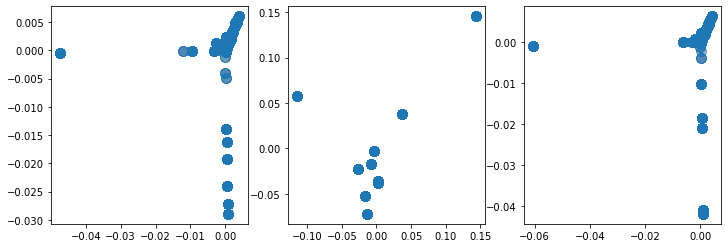

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
stride = 1
for i, proj in enumerate(all_projs):
    axes[i].scatter(proj[::stride, 0], proj[::stride, 1], alpha=0.01, s=100)

In [8]:
max_evs = 10
projs_1 = get_all_projections(max_evs, msm_1)
paths, _ = projection_paths(MD_trajectories=files,  MD_top=pdb, projected_trajectories=projs_1, n_projs=5, proj_dim=5, n_geom_samples=100, n_points=200)

Obtaining file info:   0%|                                                                                    …

getting output of RegularSpaceClustering:   0%|                                                               …

getting output of RegularSpaceClustering:   0%|                                                               …

getting output of RegularSpaceClustering:   0%|                                                               …

getting output of RegularSpaceClustering:   0%|                                                               …

getting output of RegularSpaceClustering:   0%|                                                               …

In [9]:
mod_1_path_1 = paths[0]['min_rmsd']['geom']
mod_1_path_2 = paths[1]['min_rmsd']['geom']

mod_1_path_1.save_xtc('mod_1_path_1.xtc')
mod_1_path_2.save_xtc('mod_1_path_2.xtc')

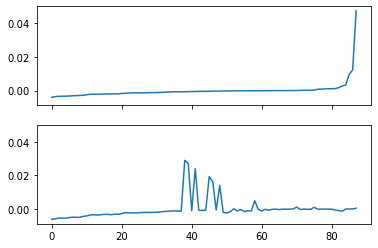

In [10]:
proj_path = paths[0]['min_disp']['proj']
fig, axes = plt.subplots(2, sharex=True, sharey=True)
for i in range(2):
    axes[i].plot(proj_path[:, i])

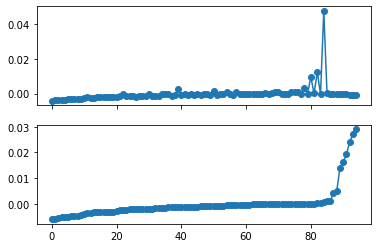

In [11]:
proj_path = paths[1]['min_disp']['proj']
fig, axes = plt.subplots(2, sharex=True)
for i in range(2):
    axes[i].plot(proj_path[:, i], marker='o')

Paths from model 1 in model 2:

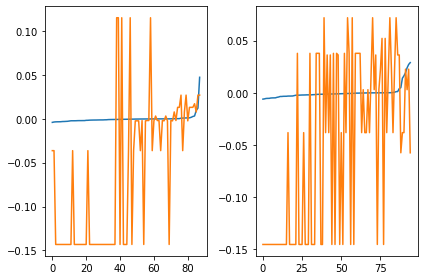

In [12]:
data_b_m1_p1 = pyemma.coordinates.load(['mod_1_path_1.xtc'], features=distances_feat)
data_b_m1_p2 = pyemma.coordinates.load(['mod_1_path_2.xtc'], features=distances_feat)

ttrajs_2_m1_p1 = tica_2.transform(data_b_m1_p1)
dtrajs_2_m1_p1 = kmeans_2.transform(ttrajs_2_m1_p1)
path_2_m1_p1 = msm_2.eigenvectors_left(2)[-1, :][dtrajs_2_m1_p1]

fig, axes = plt.subplots(1, 2)
axes[0].plot(paths[0]['min_rmsd']['proj'][:, 0])
axes[0].plot(path_2_m1_p1.flatten())

ttrajs_2_m1_p2 = tica_2.transform(data_b_m1_p2)
dtrajs_2_m1_p2 = kmeans_2.transform(ttrajs_2_m1_p2)
path_2_m1_p2 = msm_2.eigenvectors_left(3)[-1, :][dtrajs_2_m1_p2]
axes[1].plot(paths[1]['min_rmsd']['proj'][:, 1])
axes[1].plot(path_2_m1_p2.flatten())
plt.tight_layout()

Paths from model 1 in model 3:

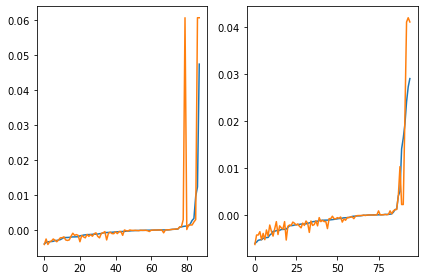

In [13]:
data_a_m1_p1 = pyemma.coordinates.load(['mod_1_path_1.xtc'], features=torsions_feat)
data_a_m1_p2 = pyemma.coordinates.load(['mod_1_path_2.xtc'], features=torsions_feat)

ttrajs_3_m1_p1 = tica_3.transform(data_a_m1_p1)
dtrajs_3_m1_p1 = kmeans_3.transform(ttrajs_3_m1_p1)
path_3_m1_p1 = msm_3.eigenvectors_left(2)[-1, :][dtrajs_3_m1_p1]

fig, axes = plt.subplots(1, 2)
axes[0].plot(paths[0]['min_rmsd']['proj'][:, 0])
axes[0].plot(-1*path_3_m1_p1.flatten())

ttrajs_3_m1_p2 = tica_3.transform(data_a_m1_p2)
dtrajs_3_m1_p2 = kmeans_3.transform(ttrajs_3_m1_p2)
path_3_m1_p2 = msm_3.eigenvectors_left(3)[-1, :][dtrajs_3_m1_p2]
axes[1].plot(paths[1]['min_rmsd']['proj'][:, 1])
axes[1].plot(-1*path_3_m1_p2.flatten())
plt.tight_layout()